# Modifications Shallow BCI Competition

## Requirements from google doc, slightly updated

Shallow net:
* <span style="color:darkgreen">Shallow net with log(mean) pooling and square</span>
* <span style="color:darkgreen">Shallow net with sqrt(mean) pooling and square (equivalent to no activation and l2-pooling)</span>
* <span style="color:darkgreen">Shallow net with log(mean) pooling and square elu </span>
* <span style="color:darkgreen">Shallow net with max pooling and elu</span>
* <span style="color:darkgreen">Shallow net with mean pooling and elu (l1-pooling)</span>
* <span style="color:darkgreen">Best of the above -> batch_norm on/off</span>
* <span style="color:darkgreen">Best of the above -> dropout on/off</span>
* <span style="color:darkgreen"> Best of the above -> split/don’t split first layer filter</span>
* <span style="color:darkgreen"> Best of the above -> (Tied loss on/off)</span>
* (Best of the above -> more/less filters)


## Overview

My baseline is log(mean(square)) with split first convolution, tied loss, dropout and batch norm.

Std is standard deviations of differences (std over the 9 datasets). Perm is p-value of one-sided permutation/randomization test. I bolded those below 0.01.

|Variant|Acc|Diff|Std|Perm|
|-|
|Baseline|74.4|-|-|-|
|sqrt(mean(square))|69.4|-4.9|4.4|**0.0098**|
|log(mean(square(elu)))|72.2|-2.2|2.8|0.043|
|max(elu)|67.9|-6.5|2.8|**0.002**|
|mean(elu)|64.8|-9.6|5.5|**0.004**|
|No Dropout|73.3|-1.1|2.7|0.15|
|No BatchNorm|68.8|-5.6|5.5|**0.002**|
|No BatchNorm No Dropout|69.7|-4.7|4.3|0.016|
|Single Convolution|70.0|-4.4|2.8|**0.002**|
|Only Crossentropy|72.5|-1.9|4.7|0.19|





## Details
I additionally show a plot with the baseline accuracies vs the variant accuracies: Blue dots above black dotted line are datasets where variant is better, below line variant is worse

## Shallow Net

### Nonlinearities

#### Sqrt(Mean(Square))

|Baseline (log(mean(square)))|sqrt(mean(square))|Diff|Std|Perm|
|-|
|74.4|69.4|-4.9|4.4|0.009766|


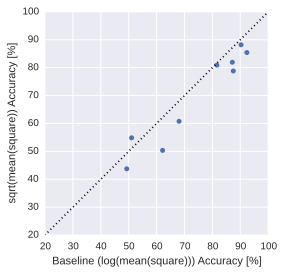

In [91]:
show_results(misclasses_baseline, misclasses_square_sqrt, second_name='sqrt(mean(square))')

#### Log(Mean(Square(Elu)))

|Baseline (log(mean(square)))|log(mean(square(elu)))|Diff|Std|Perm|
|-|
|74.4|72.2|-2.2|2.8|0.042969|


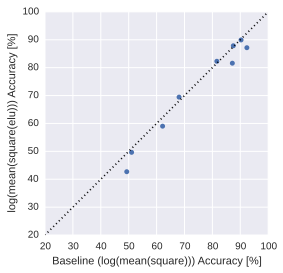

In [92]:
show_results(misclasses_baseline, misclasses_elu_square_log,
                                second_name='log(mean(square(elu)))')

#### Max (Elu)

|Baseline (log(mean(square)))|max(elu)|Diff|Std|Perm|
|-|
|74.4|67.9|-6.5|2.8|0.001953|


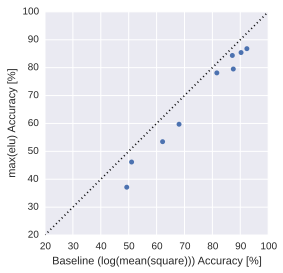

In [93]:
show_results(misclasses_baseline, misclasses_elu_max, second_name='max(elu)')

#### Mean(Elu)

|Baseline (log(mean(square)))|mean(elu)|Diff|Std|Perm|
|-|
|74.4|64.8|-9.6|5.5|0.003906|


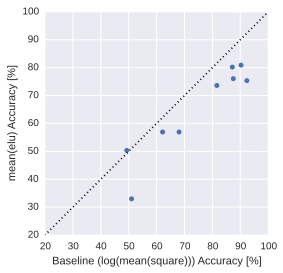

In [94]:
show_results(misclasses_baseline, misclasses_elu_mean, second_name='mean(elu)')

### Dropout 

|Dropout|No Dropout|Diff|Std|Perm|
|-|
|74.4|73.3|-1.1|2.7|0.150391|


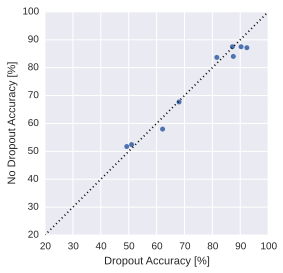

In [95]:
show_results(misclasses_baseline, misclasses_no_dropout,
             first_name='Dropout', second_name='No Dropout')

### Batch Norm

|BatchNorm|No BatchNorm|Diff|Std|Perm|
|-|
|74.4|68.8|-5.6|5.5|0.001953|


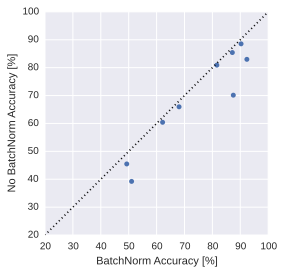

In [96]:
show_results(misclasses_baseline, misclasses_no_bnorm,
             first_name='BatchNorm', second_name='No BatchNorm')

## No BatchNorm No Dropout

|BatchNorm And Dropout|No BatchNorm No Dropout|Diff|Std|Perm|
|-|
|74.4|69.7|-4.7|4.3|0.015625|


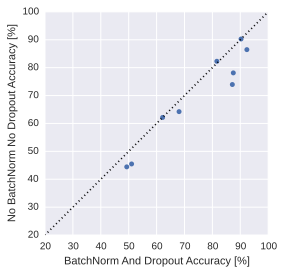

In [19]:
show_results(misclasses_baseline, misclasses_no_bnorm_no_drop,
             first_name='BatchNorm And Dropout', second_name='No BatchNorm No Dropout')

### Split Convolution

|Split Convolution|Single Convolution|Diff|Std|Perm|
|-|
|74.4|70.0|-4.4|2.8|0.001953|


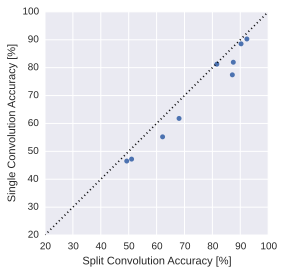

In [97]:
show_results(misclasses_baseline, misclasses_merged_layer, 
             first_name='Split Convolution', second_name='Single Convolution')

### Tied loss

|Tied + Crossentropy Loss|Only Crossentropy|Diff|Std|Perm|
|-|
|74.4|72.5|-1.9|4.7|0.185547|


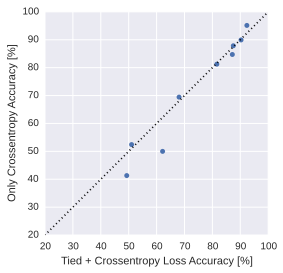

In [98]:
show_results(misclasses_baseline, misclasses_no_tied_loss, 
             first_name='Tied + Crossentropy Loss', second_name='Only Crossentropy')

# Code

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.csp.print_results import CSPResultPrinter
import logging
log = logging.getLogger()
log.setLevel("DEBUG")

In [2]:
from braindecode.results.results import (load_dataset_grouped_result_objects_for,
                                         get_final_misclasses,
                                         sort_results_by_filename,
                                        extract_single_group_misclasses_sorted)
from braindecode.analysis.stats import perm_mean_diffs
from braindecode.analysis.plot_util import show_misclass_scatter_plot

def show_results(first_misclasses, second_misclasses, first_name='Baseline (log(mean(square)))',
                 second_name=''):
   
    plot_misclass_scatter_with_name(first_misclasses, second_misclasses,
                                    first_name, second_name)
    diffs = perm_mean_diffs(first_misclasses,second_misclasses)

    actual_diff = np.mean(first_misclasses - second_misclasses)

    # one sided without checking direction before
    perm_p_val = (np.sum(abs(diffs) >= abs(actual_diff)) / 
            (float(len(diffs) * 2.0)))
    print("|{:s}|{:s}|{:s}|{:s}|{:s}|".format(first_name, second_name, "Diff", "Std", "Perm"))
    print("|-|")
    print("|{:.1f}|{:.1f}|{:.1f}|{:.1f}|{:f}|".format(100 * (1-np.mean(first_misclasses)), 
                                               100 * (1-np.mean(second_misclasses)),
                                               100 * actual_diff, # - to get accuracy from misclass
                                               100 * np.std(second_misclasses - first_misclasses),
                                                perm_p_val))
    
def plot_misclass_scatter_with_name(first_misclasses, second_misclasses, first_name='Baseline (log(mean(square)))',
                 second_name=''):
    show_misclass_scatter_plot(first_misclasses, second_misclasses)
    plt.xlabel('{:s} Accuracy [%]'.format(first_name))
    plt.ylabel('{:s} Accuracy [%]'.format(second_name))

## Shallow Net

In [3]:
# Shallow net with log(mean) pooling and square
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(sets=False,
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', drop_p=None,
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid   std    
0   9      0:12:03  0:02:38  68.95%       15.06%  74.38%  16.08%  95.35%        2.41%  99.00%  0.90%  91.71%        4.20%  95.90%  4.03%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:12:03|0:02:38|68.95%|15.06%|74.38%|16.08%|95.35%|2.41%|99.00%|0.90%|91.71%|4.20%|95.90%|4.03%|


In [4]:
misclasses_baseline = extract_single_group_misclasses_sorted(
    'data/models/paper/bci-competition/cnt/shallow/',
    params=dict(resample_fs=250,post_pool_nonlin='$safe_log', low_cut_off_hz="null",
                 cnt_preprocessors='$resample_highpass_standardize',
               first_nonlin='$square', pool_mode='average_exc_pad', drop_p=None))

### Nonlinearities

#### Log vs Sqrt

In [5]:
# Shallow net with sqrt(mean) pooling and square
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(sets=False,
     params=dict(resample_fs=250,post_pool_nonlin='$sqrt', low_cut_off_hz="null",
                 cnt_preprocessors='$resample_highpass_standardize', first_nonlin='$square',
                high_cut_hz='undefined', pool_mode='average_exc_pad'))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid   std    
0   9      0:12:00  0:05:54  64.58%       14.49%  69.44%  15.97%  84.38%        6.50%  90.08%  5.44%  78.41%        8.60%  84.89%  9.79%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:12:00|0:05:54|64.58%|14.49%|69.44%|15.97%|84.38%|6.50%|90.08%|5.44%|78.41%|8.60%|84.89%|9.79%|


|Baseline (log(mean(square)))|sqrt(mean(square))|Diff|Std|Perm|
|-|
|74.4|69.4|-4.9|4.4|0.009766|


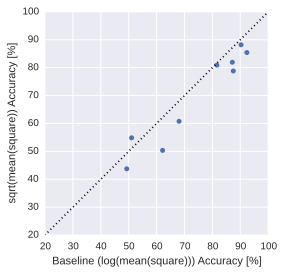

In [6]:
misclasses_square_sqrt = extract_single_group_misclasses_sorted('data/models/paper/bci-competition/cnt/shallow/',
                 params=dict(resample_fs=250,post_pool_nonlin='$sqrt', low_cut_off_hz="null",
                 cnt_preprocessors='$resample_highpass_standardize',
                high_cut_hz='undefined', pool_mode='average_exc_pad',
                            first_nonlin='$square'))

show_results(misclasses_baseline, misclasses_square_sqrt, second_name='sqrt(mean(square))')

### log(mean(square(elu)))

In [7]:
# Shallow net with log(mean) pooling and elusquare
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(
     params=dict(resample_fs=250,post_pool_nonlin='$safe_log', low_cut_off_hz="null",
                 cnt_preprocessors='$resample_highpass_standardize',
                 first_nonlin='$elu_square',
                high_cut_hz='undefined', pool_mode='average_exc_pad'))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid   std    
0   9      0:10:02  0:03:29  67.42%       15.57%  72.18%  16.77%  93.27%        4.40%  97.96%  3.32%  89.01%        7.01%  95.82%  4.90%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:10:02|0:03:29|67.42%|15.57%|72.18%|16.77%|93.27%|4.40%|97.96%|3.32%|89.01%|7.01%|95.82%|4.90%|


|Baseline (log(mean(square)))|log(mean(square(elu)))|Diff|Std|Perm|
|-|
|74.4|72.2|-2.2|2.8|0.042969|


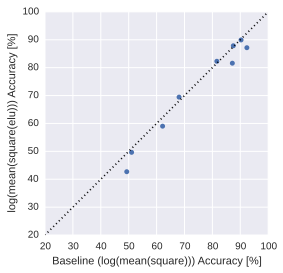

In [8]:
misclasses_elu_square_log = extract_single_group_misclasses_sorted('data/models/paper/bci-competition/cnt/shallow/',
                 params=dict(resample_fs=250,post_pool_nonlin='$safe_log', low_cut_off_hz="null",
                 cnt_preprocessors='$resample_highpass_standardize',
                 first_nonlin='$elu_square',
                high_cut_hz='undefined', pool_mode='average_exc_pad'))

show_results(misclasses_baseline, misclasses_elu_square_log, second_name='log(mean(square(elu)))')

##### comparison, also with sqrt

In [9]:
# just for comparison
# Shallow net with log(mean) pooling and elusquare
ResultPrinter('data/models/paper/ours/cnt/shallow/').print_results(sets=False,
     params=dict(resample_fs=250,post_pool_nonlin='$sqrt', low_cut_off_hz="null",
                 cnt_preprocessors='$resample_highpass_standardize',
                 first_nonlin='$elu_square',
                high_cut_hz='undefined', pool_mode='average_exc_pad'))

Printing results in data/models/paper/ours/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std    test    std    train_sample  std    train   std    valid_sample  std    valid   std    
0   20     0:26:17  0:11:50  80.70%       9.52%  86.88%  8.32%  92.16%        4.97%  96.71%  2.84%  91.14%        6.07%  96.09%  4.06%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|20|0:26:17|0:11:50|80.70%|9.52%|86.88%|8.32%|92.16%|4.97%|96.71%|2.84%|91.14%|6.07%|96.09%|4.06%|


#### max(elu)

In [10]:
# Shallow net with max pooling and elu
ResultPrinter('data/models/paper/bci-competition//cnt/shallow/').print_results(sets=False,
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$elu', pool_mode='max',
                 cnt_preprocessors='$resample_highpass_standardize'
                ))

Printing results in data/models/paper/bci-competition//cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid   std    
0   9      0:11:48  0:03:23  62.79%       15.94%  67.86%  17.85%  97.31%        3.71%  99.46%  1.41%  95.30%        5.58%  98.99%  2.86%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:11:48|0:03:23|62.79%|15.94%|67.86%|17.85%|97.31%|3.71%|99.46%|1.41%|95.30%|5.58%|98.99%|2.86%|


|Baseline (log(mean(square)))|max(elu)|Diff|Std|Perm|
|-|
|74.4|67.9|-6.5|2.8|0.001953|


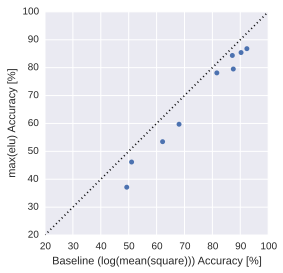

In [11]:
misclasses_elu_max = extract_single_group_misclasses_sorted('data/models/paper/bci-competition//cnt/shallow/',
                 params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$elu', pool_mode='max',
                 cnt_preprocessors='$resample_highpass_standardize'
                ))

show_results(misclasses_baseline, misclasses_elu_max, second_name='max(elu)')

#### Mean(Elu)

In [12]:
#  Shallow net with mean pooling and elu (l1-pooling)
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$elu', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize'
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std     train   std     valid_sample  std     valid   std     
0   9      0:09:58  0:03:59  58.74%       15.02%  64.81%  15.48%  70.94%        17.10%  80.36%  18.18%  66.67%        15.55%  78.40%  16.86%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:09:58|0:03:59|58.74%|15.02%|64.81%|15.48%|70.94%|17.10%|80.36%|18.18%|66.67%|15.55%|78.40%|16.86%|


|Baseline (log(mean(square)))|mean(elu)|Diff|Std|Perm|
|-|
|74.4|64.8|-9.6|5.5|0.003906|


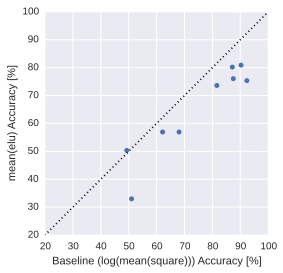

In [13]:
misclasses_elu_mean = extract_single_group_misclasses_sorted('data/models/paper/bci-competition/cnt/shallow/',
                 params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$elu', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize'
                ))

show_results(misclasses_baseline, misclasses_elu_mean, second_name='mean(elu)')

## Dropout vs no Dropout

In [14]:
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(sets=False,
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                            drop_p=0.0, layers='$cnt_shallow_square'
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std     valid_sample  std     valid   std     
0   9      0:08:10  0:01:42  68.30%       14.44%  73.30%  14.85%  91.38%        9.54%  94.98%  10.42%  87.58%        12.22%  91.15%  13.03%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:08:10|0:01:42|68.30%|14.44%|73.30%|14.85%|91.38%|9.54%|94.98%|10.42%|87.58%|12.22%|91.15%|13.03%|


|with dropout|no dropout|Diff|Std|Perm|
|-|
|74.4|73.3|-1.1|2.7|0.150391|


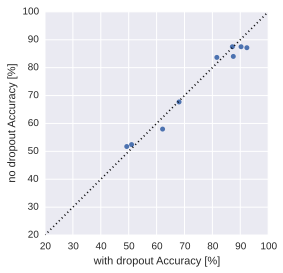

In [15]:
misclasses_no_dropout = extract_single_group_misclasses_sorted('data/models/paper/bci-competition//cnt/shallow/',
                params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                            drop_p=0.0, layers='$cnt_shallow_square'
                ))


show_results(misclasses_baseline, misclasses_no_dropout, first_name='with dropout', second_name='no dropout')

## batch norm vs no batch norm (w and w/out dropout)

In [16]:
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                           layers='$cnt_shallow_square_no_bnorm'
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  drop_p  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std     valid   std    
0   9      0.5     0:12:43  0:05:23  64.29%       15.53%  68.79%  16.70%  88.40%        8.49%  94.64%  6.65%  83.09%        10.03%  89.51%  9.00%  
1   9      0.0     0:10:05  0:02:33  64.69%       15.06%  69.71%  15.86%  89.12%        6.61%  95.52%  4.27%  84.36%        8.36%   91.39%  6.78%  

Markdown Table

|id|files|drop_p|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0.5|0:12:43|0:05:23|64.29%|15.53%|68.79%|16.70%|88.40%|8.49%|94.64%|6.65%|83.09%|10.03%|89.51%|9.00%|
|1|9|0.0|0:10:05|0:02:33|64.69%|15.06%|69.71%|15.86%|89.12%|6.61%|95.52%|4.27%|84.36%|8.36%|91.39%|6.78%|


|BatchNorm|No BatchNorm|Diff|Std|Perm|
|-|
|74.4|68.8|-5.6|5.5|0.001953|


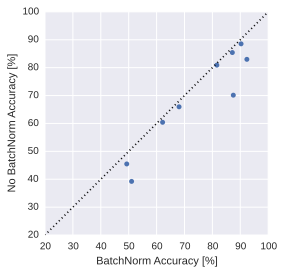

In [17]:
misclasses_no_bnorm = extract_single_group_misclasses_sorted(
    'data/models/paper/bci-competition//cnt/shallow/',
                params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                            drop_p=0.5, layers='$cnt_shallow_square_no_bnorm'
                ))

show_results(misclasses_baseline, misclasses_no_bnorm, first_name='BatchNorm', second_name='No BatchNorm')

|BatchNorm|No BatchNorm No Dropout|Diff|Std|Perm|
|-|
|74.4|69.7|-4.7|4.3|0.015625|


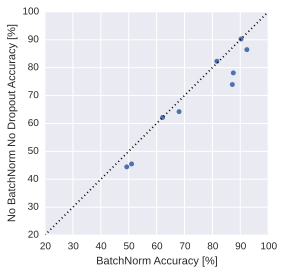

In [18]:
misclasses_no_bnorm_no_drop = extract_single_group_misclasses_sorted('data/models/paper/bci-competition/cnt/shallow/',
                params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                            drop_p=0.0, layers='$cnt_shallow_square_no_bnorm'
                ))

show_results(misclasses_baseline, misclasses_no_bnorm_no_drop, 
             first_name='BatchNorm', second_name='No BatchNorm No Dropout')

## Split Layer

In [80]:
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                 layers='$cnt_shallow_merged'
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid   std    
0   9      0:09:33  0:02:24  65.84%       15.17%  70.02%  16.45%  93.73%        3.81%  98.03%  2.50%  89.98%        7.07%  94.81%  6.94%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:09:33|0:02:24|65.84%|15.17%|70.02%|16.45%|93.73%|3.81%|98.03%|2.50%|89.98%|7.07%|94.81%|6.94%|


|Split Convolution|Single Convolution|Diff|Std|Perm|
|-|
|74.4|70.0|-4.4|2.8|0.001953|


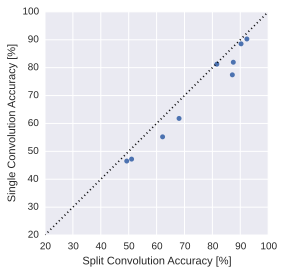

In [81]:
misclasses_merged_layer = extract_single_group_misclasses_sorted(
    'data/models/paper/bci-competition/cnt/shallow/',
                params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 post_pool_nonlin='$safe_log', high_cut_hz='undefined',
                 layers='$cnt_shallow_merged'
                ))

show_results(misclasses_baseline, misclasses_merged_layer, 
             first_name='Split Convolution', second_name='Single Convolution')

### Tied loss

In [82]:
ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results(
     params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 layers='$cnt_shallow_square',
                 post_pool_nonlin='$safe_log',
                 loss_expression='$categorical_crossentropy'
                ))

Printing results in data/models/paper/bci-competition/cnt/shallow/:


Dataset-Averaged Results:

Terminal Table

id  files  time     std      test_sample  std     test    std     train_sample  std    train   std    valid_sample  std    valid    std    
0   9      0:11:40  0:03:26  67.72%       16.95%  72.45%  18.76%  98.21%        1.59%  99.69%  0.87%  97.54%        2.17%  100.00%  0.00%  

Markdown Table

|id|files|time|std|test_sample|std|test|std|train_sample|std|train|std|valid_sample|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|9|0:11:40|0:03:26|67.72%|16.95%|72.45%|18.76%|98.21%|1.59%|99.69%|0.87%|97.54%|2.17%|100.00%|0.00%|


|Tied + Crossentropy Loss|Only Crossentropy|Diff|Std|Perm|
|-|
|74.4|72.5|-1.9|4.7|0.185547|


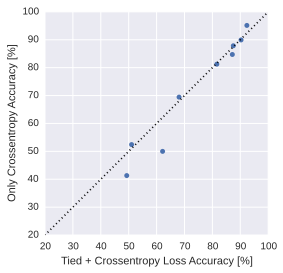

In [83]:
misclasses_no_tied_loss = extract_single_group_misclasses_sorted('data/models/paper/bci-competition/cnt/shallow/',
                params=dict(resample_fs=250, low_cut_off_hz="null",
                 first_nonlin='$square', pool_mode='average_exc_pad',
                 cnt_preprocessors='$resample_highpass_standardize',
                 layers='$cnt_shallow_square',
                 post_pool_nonlin='$safe_log',
                 loss_expression='$categorical_crossentropy'
                ))

show_results(misclasses_baseline, misclasses_no_tied_loss, 
             first_name='Tied + Crossentropy Loss', second_name='Only Crossentropy')

### Final len 32

|Final length 30|Final length 32|Diff|Std|Perm|
|-|
|74.4|72.5|-1.9|2.3|0.019531|


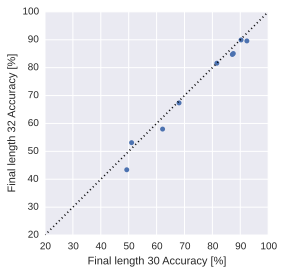

In [84]:
misclasses_final_len_32 = extract_single_group_misclasses_sorted(
    'data/models/paper/bci-competition//cnt/shallow/',
     params=dict(resample_fs=250, loss_expression='$tied_neighbours',
               cnt_preprocessors='$resample_highpass_standardize',
               layers='$cnt_shallow_square', first_nonlin='$square',
               low_cut_off_hz='null', post_pool_nonlin='$safe_log',
               pool_mode='average_exc_pad', drop_p=0.5, final_dense_length=32))

show_results(misclasses_baseline, misclasses_final_len_32, 
             first_name='Final length 30', second_name='Final length 32')